In [36]:
import pandas as pd
import numpy as np

prods = pd.read_csv("prods.csv")
actions = pd.read_csv("actions.csv")
buyers = pd.read_csv("buyers.csv")


def nan_1_and_0(df, only_value):
    df.loc[df == only_value] = 1
    df.fillna(0)


### Prods

# ['_id', 'b', 'c', 'createdat', 'd', 'deleted', 'deleteddate', 'n', 'o', 'p', 'slug', 'sp', 'surl', 'updatedat', 'deletedat', 'value']
prods.columns = ["id1", "id2", "id3", "create_date", "description", "deleted", "deleteddate", "product_name", "id4", "id5", "name", "picture", "surl", "updated_date", "deleted_date", "category"]

# remove columns with all NaNs
for unused_col in ["deleteddate", "surl"]:
    del prods[unused_col]

# Split categories by __, and store
#for i in range(3):
#    prods["category"+str(i)] = prods["category"].str.split("__").str[i]


prods = prods.drop_duplicates()
prods2 = prods.groupby(["name"]).agg({
    "category": {
        "joined_category": lambda x: " ".join([y if isinstance(y, str) else str(y) for y in x ]),
        "count": lambda x: len(x)
    },
    "id1": {"no_of_rows": "count"}
}).reset_index()
prods2.columns = ["name"] + list(prods2.columns.droplevel(0)[1:])

del prods["category"]

### Actions
for col in actions.columns:
    if actions[col].dtype == np.object:
        unique = actions[col].describe()["unique"]
        if unique == 1:
            top = actions[col].describe()["top"]
            nan_1_and_0(actions[col], top)

actions["context_product"] = actions["context_page_path"].str.split("/").str[-1]
actions.rename(columns={"id": "actions_id"}, inplace = True)

actions2 = actions[["user_id", "context_product", "action"]].groupby(["user_id", "context_product"]).count().reset_index()

### Buyers
buyers2 = buyers.groupby(["owner"]).nunique()
del buyers2["owner"]
buyers2 = buyers2.reset_index()

buyers3 = buyers.groupby(["owner"]).count().reset_index()

buyers2 = buyers3[["owner", "_id"]].merge(buyers2[["owner", "description", "value"]], on="owner")
del buyers3
buyers2.columns = ["owner", "no_of_rows", "no_of_products", "no_of_categories"]


#actions["user_id"] == buyers["owner"]
# 5a4978af403d1a5afc74484a

#prods["name"] == actions["context_product"]
# mastrad-paris-pro-gourmet-hotcold-whipper-sst-0.5l

df = actions2.merge(buyers2, left_on="user_id", right_on="owner", how="left").merge(prods2, left_on="context_product", right_on="name", how="left")

# for missing in prods2, scrape site
#for name in df.loc[df["name"].isnull()]["context_product"].unique():
#    actions_row = actions.loc[actions["context_product"] == name].iloc[0]
#    url = actions_row["context_page_url"]
#    #TODO: scrape and add to prods



/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (28,30,33,39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/joeyism/.local/lib/python3.6/site-packages/pandas/core/groupby.py:4189: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
/home/joeyism/.local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [38]:
def action_timeline(user_id, product):
    return actions.loc[(actions["user_id"] == user_id) & (actions["context_product"] == product), ["user_id", "context_product", "action"]]

In [47]:
actions_per_user = actions2[["user_id", "action"]].groupby("user_id").sum().reset_index() #55.335 actions
actions_per_product = actions2[["context_product", "action"]].groupby("context_product").sum().reset_index()

In [48]:
def histogram(arr, xlabel="", ylabel="", title=""):
    from matplotlib import pyplot as plt
    import matplotlib.mlab as mlab

    n, bins, patches = plt.hist(arr, 50, facecolor='g', alpha=0.75)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

    plt.show()

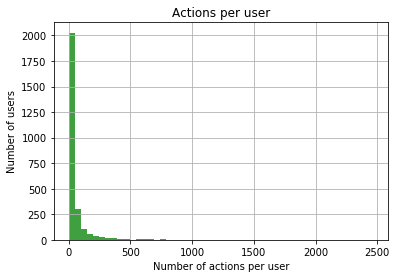

action    55.335846
dtype: float64

In [49]:
histogram(actions_per_user["action"].values, xlabel="Number of actions per user", ylabel="Number of users", title="Actions per user")
np.mean(actions_per_user)

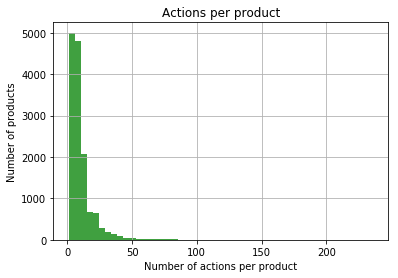

action    10.37865
dtype: float64

In [50]:
histogram(actions_per_product["action"].values, xlabel="Number of actions per product", ylabel="Number of products", title="Actions per product")
np.mean(actions_per_product)

Most active users (top ~1%)

In [60]:
actions_per_user.loc[actions_per_user["action"] > 600, "user_id"].values

array(['56a653311cbc42aa33b36398', '5786812696abf65e06db5b10',
       '57c18bfb80dd6bb621c3682e', '57dc360af351301060ed325b',
       '58013f62d75b4cec48bde14b', '580f7955c341c35c371c1f95',
       '581ca546daa18e2634c2069d', '581ca591daa18e2634c21d67',
       '58338a2118970c53da66c3df', '58347ac518970c53da66c5ca',
       '58a643bf133956643b9acf20', '58acb0c96989c159811be1dd',
       '58d189cbc9f86b2c62258849', '58e3f18b2c071f448ac01a0c',
       '58ed650ac40d93104126484f', '58f63673c0a7116aacfac917',
       '58fe0f1a0ff0495f100abfa0', '592457974a97353bd4fa741a',
       '592cdde4a2fff4117c20f33d', '59640a21a3da9e329376f499',
       '5978ef7285666906b0d899c5', '59848b9ee513cf4f5a166639',
       '599b2a2d1aebd962f8e0eaa7', '59af4f43aecc503d15c97152',
       '59c2cdf0aecc503d15ca6204', '59f7cac5291e0c0dee03ec36',
       '5a0830345d672b3a7079cd71', '5a1304dccf32b0357d1f0ec6',
       '5a1e1fd1ae47a04b60a204ef', '5a36a9ee16a23b76fd69ec74'], dtype=object)

Most active products (top ~1%)

In [61]:
actions_per_product.loc[actions_per_product["action"] > 120, "context_product"].values

array(['anevay-horizon-stove',
       'ayelet-naturals-pomegranate-facial-scrubor-organic-sugar-facial-scrubor-antioxidants-scrubor-exfoliating-scrubor-dry-skin-facial-scrubor-natural-facial-scrub-1',
       'bundle-beds-bundle-bed', 'doggie-dont-the-doggie-dont-device',
       'endurance-tap-inc-salted-maple-energy-gel',
       'faux-london-luxurious-fluffy-fur-hooded-jacket',
       'fuel-fudge-fuel-fudge-original', 'gosun-stove-gosun-go',
       'kangeaux-outdoors-walkabout-active-lifestyle-carrier',
       'laundreez-laundreez', 'lighterbro-classic-black-stealth',
       'minimal-minimal-insulated-flask',
       'miniwell-collapsible-water-bottle-with-filter',
       'olpro-olpro-pop-tent-blue-1', 'outback-swags-pioneer-swag-tent',
       'p.l.a.y.-pet-lifestyle-and-you-moroccan-lounge-bed',
       'precidio-design-inc.-kafe-in-the-box-coming-may-2017',
       'purpose-purpose-freeze-dried-food-and-treats',
       'roro-10-hand-crafted-halo-vase-with-1.75-insert',
       'scrubba-b